# Combinacions d'herois

**NOTA:** Moltes de les funcions que s'utilitzen estan en el document **Combinacions_herois.py**

In [1]:
# Importar llibreries necessàries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from Dades_Individuals import *
from Combinacions_herois import *


In [2]:
DataSet = pd.read_csv("../../LOL - Dataset/games.csv")
DataSet_champions = carregar_herois_cache()

# Primer mirem quines són totalment identiques
duplicated_rows = DataSet[DataSet.duplicated(keep=False)]
num_duplicated_rows = len(duplicated_rows)

# Si n'hi ha, les eliminem
DataSet_cleaned = DataSet.drop_duplicates()
DataSet_cleaned

🚀 Carregant JSON per PRIMERA vegada...


,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


Per poder visualitzar de manera més clara totes les columne que necessitem podem eliminar aquelles que, en aquest moment, no anem a utilitzar.

In [3]:
columnes_a_eliminar = [
    'creationTime', 'gameDuration', 'seasonId'
]

DataSet_herois = DataSet_cleaned.drop(columnes_a_eliminar, axis=1)
print(f"Columnes eliminades correctament")
print(f"Columnes restants: {list(DataSet_herois.columns)}")
print(f"Dimensions del dataset: {DataSet_herois.shape}")
DataSet_herois.head(5)

Columnes eliminades correctament
Columnes restants: ['gameId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
Dimensions del dataset:

,gameId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1,2,1,1,1,1,2,8,12,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1,1,1,1,0,1,1,119,7,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1,2,1,1,1,2,0,18,4,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1,1,1,1,1,1,0,57,4,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1,2,1,1,1,1,0,19,4,...,3,0,0,1,0,86,11,201,122,18


## Preparació dades
Comencem utilitzant la funció **comptar_combinacions_equip**, la qual ens ajuda a codificar les diferents combinacions d'herois per equip, d'aquesta manera és molt més facil jugar amb les dades. 

In [ ]:
# Retorna un diccionari per poder descodificar les combinacions d'equips
combinacions_equip = comptar_combinacions_equip(DataSet_cleaned)

# Creem un nou DataFrame amb els index de les combinacions d'equips 1 i 2 
combinacions_equip_list = list(combinacions_equip.keys())
combinacions_equips_df = pd.DataFrame(combinacions_equip_list, columns=['champ1_id', 'champ2_id', 'champ3_id', 'champ4_id', 'champ5_id'])
combinacions_equips_df
combinacions_equips_df['spell_index'] = range(len(combinacions_equips_df))


,champ1_id,champ2_id,champ3_id,champ4_id,champ5_id
0,8,11,96,112,432
1,104,122,238,412,498
2,10,35,39,76,119
3,25,54,92,120,157
4,18,38,68,141,267
...,...,...,...,...,...
101444,1,33,43,99,119
101445,99,121,201,236,420
101446,11,21,25,30,56
101447,1,89,113,164,202


In [ ]:
# Aplicar la funció completa
DataSet_reduit = afegir_combinacions_equips_a_dataset(
    df=DataSet_herois,
    combinacions_equips_df=combinacions_equips_df,
)

print(f"Dimensions del dataset reduït: {DataSet_reduit.shape}")
print(f"Columnes reduïdes: {list(DataSet_reduit.columns)}")

Dimensions del dataset reduït: (51053, 60)
Columnes reduïdes: ['gameId', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5', 'team1_comb_i

In [ ]:
# Mostrar les primeres files
DataSet_reduit.head()

## Herois
Visualitzem les dades dels herois a continaució.

### Equip 1
Observem quines de les combinacions de l'equip 1 s'ha utilitzat més, quin és el seu percentatge de victoria i mirar de quins herois esta compost.

In [ ]:
# Obtenim les dades on l'equip 1 ha guanyat
DataSet_herois_1 = DataSet_reduit[DataSet_reduit['winner'] == 1]
count = DataSet_herois_1['team1_comb_index'].value_counts()

max = count.max()
min = count.min()

print(f"El nombre màxim de combinacions d'herois que ha guanyat un equip és: {max}")
print(f"El nombre mínim de combinacions d'herois que ha guanyat un equip és: {min}")

In [ ]:
combos_recomanats = crear_grafica_i_analisi_de_combinacions_guanyades(DataSet_reduit, 'team1_comb_index', 1)

In [ ]:
# Obtenir les dades dels herois recomanats en format DataFrame
print("="*80)
print("DADES DELS HEROIS A LES COMBINACIONS RECOMANADES")
print("="*80)

herois_data = obtenir_dades_herois(combos_recomanats, combinacions_equips_df)

# Crear el DataFrame
df_herois_recomanats = pd.DataFrame(herois_data)

print("\nDataFrame amb els herois de les combinacions recomanades:")
print("="*80)
print(df_herois_recomanats.to_string(index=False))
print("="*80)

# Mostrar estadístiques
print(f"\nTotal de combinacions: {df_herois_recomanats['combo_idx'].nunique()}")
print(f"Total de herois únics: {df_herois_recomanats['heroi_id'].nunique()}")

df_herois_recomanats

En aquest cas, només ens trobem amb un cas que obté una taxa de victòria de més del 90%, del 100%. Com podem apreciar, en les dades de cadascun dels herois, observem que tenen un tag que determina quines accions o quines són les seves responsabilitats. 

**Nota:** Tenim en compte que en aquest cas tingui un 100% de taxa de victòria pot ser enganyos.

Només em obtingut una combinació amb una taxa alta, crec que el millor pas, en aquest cas, seria mirar contra quins herois estaven competint, però això ho veurem més endavant.

El següent punt a observar és quins tags són els més utilitzats, quin és l'equilibri entre la quantitat de tags que té una combinació d'herois i la taxa de victoria.

In [ ]:
herois_team1_win_com = count.copy()

data_herois = obtenir_dades_herois(herois_team1_win_com, combinacions_equips_df)
data_herois_df = pd.DataFrame(data_herois)
tags_count = data_herois_df['tags'].value_counts()
len(tags_count)
tags_count


In [ ]:

data_herois_df['tags'] = data_herois_df['tags'].str.split(',')

# Després fer el mateix procés
tags_exploded = data_herois_df['tags'].explode()
tags_count_ind = tags_exploded.value_counts()

tags_count_ind

Amb aquesta comparativa podem extreure les següents conclusions:
- El Tag d'heroi més utilitzat és el de **Mage**.
    - En la majoria de les combinacions de Tag, sempre està.
- No importa el Tag sol, sinó la combinació d'ells per determinar quin és l'heroi que millor funciona.

In [ ]:
# Obtenir tags més comuns
top_n = 5
top_tags = data_herois_df['tags'].dropna().explode().value_counts().head(top_n).index
top_tags_set = set(top_tags)

# Crear una columna temporal amb el nombre de tags coincidents
def count_matching_tags(tags_list):
    if not isinstance(tags_list, list):
        return 0
    return sum(1 for tag in tags_list if tag in top_tags_set)

data_herois_df['matching_tags_count'] = data_herois_df['tags'].apply(count_matching_tags)

# Filtrar herois amb almenys 1 tag coincident i ordenar per rellevància
millors_herois_df = data_herois_df[data_herois_df['matching_tags_count'] > 0]
millors_herois_df = millors_herois_df.sort_values('matching_tags_count', ascending=False)

# Eliminar la columna temporal (opcional)
millors_herois_df = millors_herois_df.drop(columns=['matching_tags_count'])

# Guardar en llista
millors_herois = millors_herois_df.to_dict('records')
millors_herois_df = pd.DataFrame(millors_herois)
print(f"Obtenim un total de {len(millors_herois)} que tenen les 5 combinacions de tags amb més victories ({top_tags})")

millors_herois_df.head(5)

D'acord, ara que tenim això, podem fer una comparativa amb el següent equip

### Equip 2

In [ ]:
# Obtenim les dades on l'equip 2 ha guanyat
DataSet_herois_2 = DataSet_reduit[DataSet_reduit['winner'] == 2]
count = DataSet_herois_2['team2_comb_index'].value_counts()

max_val = count.max()
min_val = count.min()

print(f"El nombre màxim de combinacions d'herois que ha guanyat un equip és: {max_val}")
print(f"El nombre mínim de combinacions d'herois que ha guanyat un equip és: {min_val}")

In [ ]:
combos_recomanats = crear_grafica_i_analisi_de_combinacions_guanyades(DataSet_reduit, 'team2_comb_index', 2)

In [ ]:
# Obtenir les dades dels herois recomanats en format DataFrame
print("="*80)
print("DADES DELS HEROIS A LES COMBINACIONS RECOMANADES")
print("="*80)

herois_recomanats_data = obtenir_dades_herois(combos_recomanats, combinacions_equips_df)

# Crear el DataFrame
df_herois_recomanats = pd.DataFrame(herois_recomanats_data)

print("\nDataFrame amb els herois de les combinacions recomanades:")
print("="*80)
print(df_herois_recomanats.to_string(index=False))
print("="*80)

# Mostrar estadístiques
print(f"\nTotal de combinacions: {df_herois_recomanats['combo_idx'].nunique()}")
print(f"Total de herois únics: {df_herois_recomanats['heroi_id'].nunique()}")

df_herois_recomanats

In [ ]:
herois_team2_win_com = count.copy()

data_herois = obtenir_dades_herois(herois_team2_win_com, combinacions_equips_df)
data_herois_df = pd.DataFrame(data_herois)
tags_count = data_herois_df['tags'].value_counts()
len(tags_count)
tags_count


In [ ]:
# Obtenir tags més comuns
top_n = 5
top_tags = data_herois_df['tags'].dropna().explode().value_counts().head(top_n).index
top_tags_set = set(top_tags)

# Crear una columna temporal amb el nombre de tags coincidents
def count_matching_tags(tags_list):
    if not isinstance(tags_list, list):
        return 0
    return sum(1 for tag in tags_list if tag in top_tags_set)

data_herois_df['matching_tags_count'] = data_herois_df['tags'].apply(count_matching_tags)

# Filtrar herois amb almenys 1 tag coincident i ordenar per rellevància
millors_herois_df = data_herois_df[data_herois_df['matching_tags_count'] > 0]
millors_herois_df = millors_herois_df.sort_values('matching_tags_count', ascending=False)

# Eliminar la columna temporal (opcional)
millors_herois_df = millors_herois_df.drop(columns=['matching_tags_count'])

# Guardar en llista
millors_herois = millors_herois_df.to_dict('records')
millors_herois_df = pd.DataFrame(millors_herois)
print(f"Obtenim un total de {len(millors_herois)} que tenen les 5 combinacions de tags amb més victories ({top_tags})")

millors_herois_df.head(5)

### Combinació entre els herois de cada equip
Anem a comparar les combinacions de campions de cada equip i comparar-los

In [ ]:
resultats = analisi_profund_combinacions_compartides(DataSet_reduit, combinacions_equips_df)
resultats

Ens em trobat amb **92 combinacions de campions** els quals s'han fet servir pels dos equips anteriorment i que han guanyat.

A continuació, mirarem quines combinacions han funcionat correctamet per un equip, però malament amb l'altre.

In [ ]:
# Equip 1
obtenir_combinacions_unilaterals(DataSet_reduit, 1)
# Equip 2

obtenir_combinacions_unilaterals(DataSet_reduit, 2)

Per sorpresa no trobem a **cap** combinació que funcioni millor en un equip que en un altre.

#### Correlacions entre combinacions
Analitzar correlacions entre diferents combinacions de campions

In [ ]:
print("ANÀLISI 1: Correlacions entre combinacions similars")
correl_df, win_rates, combos_sel = analitzar_correlacions_performance_optimitzat(
    DataSet_reduit, 
    combinacions_equips_df,
    top_n=200  
)

Aquí tenim un problema , sens diu que hi ha un total de **101499 combinacions úniques**, però sabem que no ja que la funció "analisi_profund_combinacions_compartides" havia determinat **50470 combinacions úniques**

In [ ]:
total_partides = len(DataSet_reduit)
combinacions_úniques = 101449
ratio = combinacions_úniques/total_partides
ratio

Ara podem determinar que cada partida té combinacions úniques. Gairabé no es repeteixen.

- Les combinacions no es reutilitzen
- No es poden trobar "millors combinacions" perquè cada una només apareix 1-2 vegades.
- Que obtinguem un **winrate = 100%** no és significatiu, ja que només pot haver guanyat 1 o 2 partides.

In [ ]:
# Executar l'anàlisi real
diversitat = analisi_real_diversitat(DataSet_reduit, combinacions_equips_df)

Aquests gràfics demostren les nostres conclusions anteriors, moltes d'aquestes combinacions només apareixen 1 vegada.

#### Correlacions contra combinacions comunes
Analitzar correlacions contra combinacions comunes

In [ ]:
print("\n\nANÀLISI 2: Rendiment contra combinacions comunes")
try:
    resultats_contra, enfrontaments = analitzar_correlacions_contra_comunes_optimitzat(
        DataSet_reduit,
        combinacions_equips_df,
        min_partides=0  # Encara més baix!
    )
    
    if resultats_contra is not None and len(resultats_contra) > 0:
        print(f"\nAnàlisi completat. Combinacions analitzades: {len(resultats_contra)}")
    else:
        print("\nAnàlisi completat però amb poques dades.")
        
except Exception as e:
    print(f"\nError durant l'anàlisi: {e}")
    resultats_contra, enfrontaments = pd.DataFrame(), {}

La funció s'ha anat provant amb un valor diferent (X = 0,1,2,3) de *min_partides*. Però fins i tot en **X=0** ens marca que en 101.449 combinacions úniques d'herois, **cap parell d'aquestes combinacions s'ha enfrontat mútuament en suficients partides** per poder analitzar, ni tan sols en 2 partides.


#### Patrons de Sinergia entre combinacions
Analitzar patrons de sinergia entre herois

In [ ]:
print("\n\nANÀLISI 3: Patterns de sinergia entre herois")
# Primer obtenir herois_data
herois_data = {}
herois_json = carregar_herois_cache()
if 'data' in herois_json:
    for champ_info in herois_json['data'].values():
        if 'id' in champ_info:
            herois_data[champ_info['id']] = champ_info

sinergia_df = analitzar_patterns_sinergia(
    DataSet_reduit, combinacions_equips_df, herois_data
)

D'acord, ara que sabem que hi ha certa sinergia entre algusns campions, en el cas que un equip tingui aquesta combinació podriem crear una nova columna per determinar aquest avantatge.

#### Anàlisi per Herois Individuals

In [ ]:
# 2. Executar anàlisi per herois individuals
print("\n\n1. ANÀLISI PER HEROIS INDIVIDUALS:")
heroi_stats = analisi_alternatiu_per_herois(
    DataSet_reduit, 
    DataSet_herois,
    combinacions_equips_df,
    min_partides=30  # Pots ajustar aquest llindar
)

##### Exepcions

- Pick rate alt, win_rate baix

In [ ]:
heroi_stats[heroi_stats['pick_rate'] > 2.5]

In [ ]:
herois1 = sinergia_df[sinergia_df['heroi1_id'] == 412]
herois2 = sinergia_df[sinergia_df['heroi2_id'] == 412]

num = len(herois1) + len(herois2)
mitjana = (sum(herois1['score_sinergia']) + sum(herois2['score_sinergia']))/num
mes = len(sinergia_df[sinergia_df['score_sinergia'] > mitjana])

print(f"Num parelles: {num}")
print(f"Mitjana sineriga amb parelles: {mitjana}")
print(f"Parelles amb més score_sinergia {mitjana}: {mes}")

Sabem que el campio "Thresh", l'excepció del campió, sorprent ja que té un total de 137 parelles amb només un **score_sinergia del 0.24** i hi han 4964 parelles amb més sinergia.

#### Anàlisi per Tags

In [ ]:
print("\n\n2. ANÀLISI PER TAGS/ROLS:")
composicions_stats, tag_stats = analisi_per_tags(
    DataSet_reduit,
    DataSet_herois,
    combinacions_equips_df,
    min_partides=3  
)

# 4. Comparar resultats
if heroi_stats is not None:
    print(f"\n✓ Anàlisi per herois completat: {len(heroi_stats)} herois analitzats")

if composicions_stats is not None:
    print(f"✓ Anàlisi per tags completat: {len(composicions_stats)} composicions analitzades")

## Implementacions al dataset per millor entrenament

D'acord, ara que sé que moltes d'aquestes combinacions entre campions no és repeteixen i només s'utilitzen entre 1 o 2 partides, no tenim proutes partides per determinar si hi ha alguan possible relació entre elles que marqui que una partida tingui més probabilitat que guanyi un equip o l'altre.

L'analisi dels herois individuals és bastant favorable, però no crec que només valorar el win_rate dels jugadors, ja que com és un joc de treball en equip, també hauriem de tenir en compte les dades dels jugadors, quins percentatges d'ús del campió tenen els jugadors, quin són els seus index i destresa, etc.

### Sinergia entre parelles de campions
El que si que em pogut descorbrir i que crec que el podem utilitzar és la sinergia que hi ha entre els diferents herois en un mateix equip.


In [6]:
def calcular_sinergia_equips(DataSet_reduit, combinacions_equips_df, sinergia_df):
    """
    Calcula el score de sinergia promig per a cada equip i l'afegeix a la base de dades.
    
    Args:
        DataSet_reduit: DataFrame amb les dades de partides
        combinacions_equips_df: DataFrame amb les combinacions d'equips
        sinergia_df: DataFrame amb les sinergies de parelles (generat per analitzar_patterns_sinergia)
    
    Returns:
        DataFrame amb les noves columnes de sinergia afegides
    """
    import pandas as pd
    import numpy as np
    import itertools
    
    # Crear un diccionari ràpid per a cercar sinergies de parelles
    sinergia_dict = {}
    for _, row in sinergia_df.iterrows():
        # Crear una clau única ordenada per a la parella
        key = tuple(sorted([int(row['heroi1_id']), int(row['heroi2_id'])]))
        sinergia_dict[key] = row['score_sinergia']
    
    # Funció per obtenir herois d'una combinació
    def obtenir_herois_combinacio(comb_index):
        if comb_index in combinacions_equips_df.index:
            row = combinacions_equips_df.loc[comb_index]
            return [
                int(row['champ1_id']),
                int(row['champ2_id']),
                int(row['champ3_id']),
                int(row['champ4_id']),
                int(row['champ5_id'])
            ]
        return []
    
    # Funció per calcular sinergia d'un equip
    def calcular_sinergia_promig_equip(herois):
        if len(herois) != 5:
            return 0.5  # Valor per defecte si no hi ha 5 herois
        
        # Generar totes les parelles possibles (10 parelles en total)
        parelles = list(itertools.combinations(sorted(herois), 2))
        
        # Obtenir scores de sinergia per a cada parella
        scores = []
        for parella in parelles:
            key = tuple(sorted(parella))
            score = sinergia_dict.get(key, 0.5)  # 0.5 per defecte si no hi ha dades
            scores.append(score)
        
        # Calcular promig, normalitzat perquè no sigui 1.0 perfecte
        if scores:
            sinergia_promig = np.mean(scores)
            # Normalitzem lleugerament per evitar valors extrems
            sinergia_promig = 0.5 + (sinergia_promig - 0.5) * 0.9
            return np.minimum(sinergia_promig, 0.95)  # CORREGIT: np.minimum en lloc de min
        return 0.5
    
    # Calcular sinergia per a cada equip en cada partida
    team1_sinergies = []
    team2_sinergies = []
    
    for idx, row in DataSet_reduit.iterrows():
        # Obtenir herois de cada equip
        herois_team1 = obtenir_herois_combinacio(row['team1_comb_index'])
        herois_team2 = obtenir_herois_combinacio(row['team2_comb_index'])
        
        # Calcular sinergia promig
        sinergia_team1 = calcular_sinergia_promig_equip(herois_team1)
        sinergia_team2 = calcular_sinergia_promig_equip(herois_team2)
        
        team1_sinergies.append(sinergia_team1)
        team2_sinergies.append(sinergia_team2)
    
    # Afegir columnes a la base de dades
    DataSet_reduit['team1_sinergia_promig'] = team1_sinergies
    DataSet_reduit['team2_sinergia_promig'] = team2_sinergies
    
    # Calcular diferència de sinergia (pot ser útil per al model)
    DataSet_reduit['sinergia_diferencia'] = DataSet_reduit['team1_sinergia_promig'] - DataSet_reduit['team2_sinergia_promig']
    
    print("="*60)
    print("ESTADÍSTIQUES DE SINERGIA AFEGIDES")
    print("="*60)
    print(f"Team1 Sinergia Promig: {DataSet_reduit['team1_sinergia_promig'].mean():.3f}")
    print(f"Team2 Sinergia Promig: {DataSet_reduit['team2_sinergia_promig'].mean():.3f}")
    print(f"Diferència Mitjana: {DataSet_reduit['sinergia_diferencia'].mean():.3f}")
    
    return DataSet_reduit


def analitzar_patterns_sinergia(DataSet_reduit, combinacions_equips_df, herois_data):
    """
    Identifica patterns de sinergia entre herois basat en co-ocurrència i win rate.
    Modificada per integrar-se amb el flux de modificació de la base de dades.
    """
    import pandas as pd
    import numpy as np
    import itertools
    from collections import defaultdict
    
    print("="*60)
    print("ANÀLISI DE SINERGIA ENTRE HEROIS")
    print("="*60)
    
    # 1. Crear diccionari d'herois per combinació
    combo_herois = {}
    for idx, row in combinacions_equips_df.iterrows():
        herois = [int(row['champ1_id']), int(row['champ2_id']), 
                 int(row['champ3_id']), int(row['champ4_id']), 
                 int(row['champ5_id'])]
        combo_herois[idx] = herois
    
    # 2. Analitzar totes les parelles possibles d'herois
    parelles_stats = defaultdict(list)
    
    for combo_idx, herois in combo_herois.items():
        # Generar totes les parelles úniques d'aquesta combinació
        parelles = list(itertools.combinations(sorted(herois), 2))
        
        # Obtenir win rate d'aquesta combinació
        mascara_team1 = DataSet_reduit['team1_comb_index'] == combo_idx
        mascara_team2 = DataSet_reduit['team2_comb_index'] == combo_idx
        
        victorias = (DataSet_reduit.loc[mascara_team1, 'winner'] == 1).sum() + \
                   (DataSet_reduit.loc[mascara_team2, 'winner'] == 2).sum()
        partides = mascara_team1.sum() + mascara_team2.sum()
        win_rate = victorias / partides if partides > 0 else 0.5
        
        # Afegir win rate a cada parella d'aquesta combinació
        for parella in parelles:
            parelles_stats[parella].append(win_rate)
    
    # 3. Calcular estadístiques per a cada parella
    results = []
    for parella, win_rates in parelles_stats.items():
        if len(win_rates) >= 2:  # Reduït a mínim 2 aparacions per tenir més dades
            avg_win_rate = np.mean(win_rates)
            std_win_rate = np.std(win_rates) if len(win_rates) > 1 else 0.1
            aparicions = len(win_rates)
            
            # Obtenir noms dels herois
            heroi1_nom = herois_data.get(parella[0], {}).get('name', f'ID:{parella[0]}')
            heroi2_nom = herois_data.get(parella[1], {}).get('name', f'ID:{parella[1]}')
            
            # Calcular consistència (inversa de la variabilitat)
            consistencia = 1 - (std_win_rate / np.maximum(avg_win_rate, 0.1))
            consistencia = np.clip(consistencia, 0, 1)  # Normalitzar entre 0 i 1
            
            # Calcular score de sinergia (més equilibrat)
            # Combina win rate i consistència, amb pes per aparicions
            pes_aparicions = np.minimum(aparicions / 10, 1)  # CORREGIT: np.minimum en lloc de min
            score_sinergia = (avg_win_rate * 0.6 + consistencia * 0.4) * pes_aparicions
            
            results.append({
                'heroi1_id': parella[0],
                'heroi2_id': parella[1],
                'heroi1_nom': heroi1_nom,
                'heroi2_nom': heroi2_nom,
                'aparicions': aparicions,
                'win_rate_promig': avg_win_rate,
                'win_rate_std': std_win_rate,
                'consistencia': consistencia,
                'score_sinergia': score_sinergia
            })
    
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # Ordenar per millor sinergia
        results_df = results_df.sort_values('score_sinergia', ascending=False).reset_index(drop=True)
        
        print(f"\nParelles analitzades: {len(results_df)}")
        print("\nTOP 10 PARELLES AMB MILLOR SINERGIA:")
        print("-" * 50)
        
        for idx, row in results_df.head(10).iterrows():
            print(f"{row['heroi1_nom']:15} + {row['heroi2_nom']:15} | "
                  f"WR: {row['win_rate_promig']:.2%} | "
                  f"Sinergia: {row['score_sinergia']:.3f} | "
                  f"Aparicions: {row['aparicions']}")
        
        # Estadístiques generals
        print("\n" + "="*50)
        print("ESTADÍSTIQUES GENERALS DE SINERGIA:")
        print("="*50)
        print(f"Score sinergia mitjà: {results_df['score_sinergia'].mean():.3f}")
        print(f"Score sinergia màxim: {results_df['score_sinergia'].max():.3f}")
        print(f"Score sinergia mínim: {results_df['score_sinergia'].min():.3f}")
        
        # Histograma de scores
        print("\nDistribució de scores de sinergia:")
        bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        hist, _ = np.histogram(results_df['score_sinergia'], bins=bins)
        for i in range(len(bins)-1):
            print(f"  {bins[i]:.1f}-{bins[i+1]:.1f}: {hist[i]} parelles")
    
    return results_df


# FLUX COMPLET D'IMPLEMENTACIÓ
def implementar_sinergia_model(DataSet_reduit, combinacions_equips_df):
    """
    Flux complet per implementar la sinergia al model.
    
    1. Analitza les sinergies entre parelles
    2. Calcula el score de sinergia promig per equip
    3. Afegeix les columnes a la base de dades original
    """
    # 1. Carregar dades dels herois
    herois_json = carregar_herois_cache()
    herois_data = {}
    if 'data' in herois_json:
        for champ_info in herois_json['data'].values():
            if 'id' in champ_info:
                herois_data[champ_info['id']] = champ_info
    
    # 2. Analitzar sinergies entre parelles
    sinergia_df = analitzar_patterns_sinergia(DataSet_reduit, combinacions_equips_df, herois_data)
    
    # 3. Calcular sinergia per equips i afegir a la base de dades
    DataSet_amb_sinergia = calcular_sinergia_equips(DataSet_reduit.copy(), combinacions_equips_df, sinergia_df)
    
    print("\n" + "="*60)
    print("IMPLEMENTACIÓ COMPLETADA")
    print("="*60)
    print(f"Columnes afegides: team1_sinergia_promig, team2_sinergia_promig, sinergia_diferencia")
    print(f"Total de files processades: {len(DataSet_amb_sinergia)}")
    
    return DataSet_amb_sinergia, sinergia_df


DataSet_amb_sinergia, sinergia_df =implementar_sinergia_model(DataSet_reduit, combinacions_equips_df)

ANÀLISI DE SINERGIA ENTRE HEROIS

Parelles analitzades: 9407

TOP 10 PARELLES AMB MILLOR SINERGIA:
--------------------------------------------------
Nidalee         + Shyvana         | WR: 92.86% | Sinergia: 0.846 | Aparicions: 14
Graves          + Hecarim         | WR: 85.00% | Sinergia: 0.759 | Aparicions: 10
Kassadin        + Udyr            | WR: 84.21% | Sinergia: 0.732 | Aparicions: 19
Nocturne        + Aurelion Sol    | WR: 84.21% | Sinergia: 0.732 | Aparicions: 19
Mordekaiser     + Camille         | WR: 93.75% | Sinergia: 0.714 | Aparicions: 8
Karthus         + Xerath          | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Rumble          + Skarner         | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Warwick         + Rek'Sai         | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Malphite        + Nocturne        | WR: 82.14% | Sinergia: 0.706 | Aparicions: 28
Anivia          + Aatrox          | WR: 81.82% | Sinergia: 0.702 | Aparicions: 11

ESTADÍSTIQUES GENERALS DE SINERGI

### Tags
S'ha trobat una correlació entre els diferents tags que tenen la combinació d'herois amb percentatge més alt que d'altres.


In [7]:
def analisi_per_tags(DataSet_reduit, DataSet_herois, combinacions_equips_df, min_partides=5):
    """
    Analitza el rendiment basat en composicions de tags/rols i afegeix score de tags a DataSet_reduit.
    Retorna DataSet_reduit amb noves columnes: team1_tag_score, team2_tag_score, tag_score_diff.
    """
    import pandas as pd
    import numpy as np
    from collections import Counter, defaultdict
    
    print("="*80)
    print("ANÀLISI PER TAGS/ROLS I CÀLCUL DE SCORE")
    print("="*80)
    
    # 1. CARREGAR I PREPARAR DADES D'HEROIS
    herois_data = carregar_herois_cache()
    
    heroi_to_tags = {}
    all_tags = set()
    
    if 'data' in herois_data:
        for champ_info in herois_data['data'].values():
            if 'id' in champ_info:
                heroi_id = champ_info['id']
                tags = champ_info.get('tags', [])
                if isinstance(tags, list):
                    heroi_to_tags[heroi_id] = tags
                    all_tags.update(tags)
    
    print(f"\n1. TAGS ÚNIQUES IDENTIFICATS: {len(all_tags)}")
    print(f"   Tags: {', '.join(sorted(all_tags))}")
    
    # 2. PREPROCESSAR SIGNATURES DE TAGS PER COMBINACIONS D'EQUIP
    print("\n2. PREPROCESSANT SIGNATURES DE TAGS PER COMBINACIONS D'EQUIP...")
    
    combo_to_signatura = {}
    signatura_to_combos = defaultdict(list)
    
    for combo_idx, row in combinacions_equips_df.iterrows():
        herois = [int(row['champ1_id']), int(row['champ2_id']), 
                  int(row['champ3_id']), int(row['champ4_id']), 
                  int(row['champ5_id'])]
        
        tags_equip = []
        for hero_id in herois:
            if hero_id in heroi_to_tags:
                tags_equip.extend(heroi_to_tags[hero_id])
        
        tag_counter = Counter(tags_equip)
        key_parts = []
        for tag in sorted(all_tags):
            if tag in tag_counter:
                key_parts.append(f"{tag}:{tag_counter[tag]}")
        
        signatura = ",".join(key_parts) if key_parts else "empty"
        combo_to_signatura[combo_idx] = signatura
        signatura_to_combos[signatura].append(combo_idx)
    
    print(f"   Combinacions processades: {len(combo_to_signatura)}")
    print(f"   Signatures úniques: {len(signatura_to_combos)}")
    
    # 3. CALCULAR ESTADÍSTIQUES PER SIGNATURA
    print("\n3. CALCULANT ESTADÍSTIQUES PER SIGNATURA...")
    
    signatura_stats = defaultdict(lambda: {'wins': 0, 'games': 0})
    total_partides = len(DataSet_herois)
    
    for idx, row in DataSet_herois.iterrows():
        winner = row['winner']
        
        for team in [1, 2]:
            tags_equip = []
            for champ in range(1, 6):
                col_name = f't{team}_champ{champ}id'
                hero_id = row[col_name]
                if pd.notna(hero_id):
                    hero_id = int(hero_id)
                    if hero_id in heroi_to_tags:
                        tags_equip.extend(heroi_to_tags[hero_id])
            
            tag_counter = Counter(tags_equip)
            key_parts = []
            for tag in sorted(all_tags):
                if tag in tag_counter:
                    key_parts.append(f"{tag}:{tag_counter[tag]}")
            signatura = ",".join(key_parts) if key_parts else "empty"
            
            signatura_stats[signatura]['games'] += 1
            equip_guanya = (team == 1 and winner == 1) or (team == 2 and winner == 2)
            if equip_guanya:
                signatura_stats[signatura]['wins'] += 1
    
    print(f"   Partides processades: {total_partides}")
    print(f"   Signatures amb dades: {len(signatura_stats)}")
    
    # 4. CALCULAR WIN_RATE PER TAG INDIVIDUAL
    print("\n4. CALCULANT WIN_RATE PER TAG INDIVIDUAL...")
    
    tag_stats = defaultdict(lambda: {'wins': 0, 'games': 0})
    
    for idx, row in DataSet_herois.iterrows():
        winner = row['winner']
        for team in [1, 2]:
            tags_equip = []
            for champ in range(1, 6):
                hero_id = row[f't{team}_champ{champ}id']
                if pd.notna(hero_id):
                    hero_id = int(hero_id)
                    if hero_id in heroi_to_tags:
                        tags_equip.extend(heroi_to_tags[hero_id])
            
            equip_guanya = (team == 1 and winner == 1) or (team == 2 and winner == 2)
            for tag in set(tags_equip):
                tag_stats[tag]['games'] += 1
                if equip_guanya:
                    tag_stats[tag]['wins'] += 1
    
    tag_win_rates = {}
    for tag, stats in tag_stats.items():
        if stats['games'] > 0:
            tag_win_rates[tag] = stats['wins'] / stats['games']
        else:
            tag_win_rates[tag] = 0.5
    
    # 5. CALCULAR SCORE DE TAGS PER SIGNATURA
    print("\n5. CALCULANT SCORE DE TAGS...")
    
    signatura_scores = {}
    for signatura, stats in signatura_stats.items():
        games = stats['games']
        wins = stats['wins']
        
        if games >= min_partides:
            score = wins / games
        else:
            if signatura == "empty":
                score = 0.5
            else:
                tags_in_signatura = []
                for part in signatura.split(','):
                    tag, count = part.split(':')
                    count = int(count)
                    for _ in range(count):
                        tags_in_signatura.append(tag)
                
                tags_unics = set(tags_in_signatura)
                if tags_unics:
                    scores_tags = [tag_win_rates.get(tag, 0.5) for tag in tags_unics]
                    score = np.mean(scores_tags)
                else:
                    score = 0.5
        
        signatura_scores[signatura] = score
    
    # 6. ASSIGNAR SCORES A LES COMBINACIONS
    combo_scores = {}
    for combo_idx, signatura in combo_to_signatura.items():
        combo_scores[combo_idx] = signatura_scores.get(signatura, 0.5)
    
    # 7. AFEGIR COLUMNES A DataSet_reduit
    print("\n6. AFEGINT SCORES DE TAGS AL DATASET...")
    
    team1_scores = []
    team2_scores = []
    
    for idx, row in DataSet_reduit.iterrows():
        combo1 = row['team1_comb_index']
        combo2 = row['team2_comb_index']
        
        score1 = combo_scores.get(combo1, 0.5)
        score2 = combo_scores.get(combo2, 0.5)
        
        team1_scores.append(score1)
        team2_scores.append(score2)
    
    DataSet_reduit['team1_tag_score'] = team1_scores
    DataSet_reduit['team2_tag_score'] = team2_scores
    DataSet_reduit['tag_score_diff'] = DataSet_reduit['team1_tag_score'] - DataSet_reduit['team2_tag_score']
    
    print(f"   Columnes afegides: team1_tag_score, team2_tag_score, tag_score_diff")
    
    # 8. ESTADÍSTIQUES I RESULTATS
    print("\n7. ESTADÍSTIQUES DE SCORES DE TAGS:")
    print(f"   Team1 tag score mitjà: {DataSet_reduit['team1_tag_score'].mean():.3f}")
    print(f"   Team2 tag score mitjà: {DataSet_reduit['team2_tag_score'].mean():.3f}")
    print(f"   Diferència mitjana: {DataSet_reduit['tag_score_diff'].mean():.3f}")
    
    # Mostrar millors composicions
    signatura_list = []
    for signatura, stats in signatura_stats.items():
        games = stats['games']
        if games > 0:
            win_rate = stats['wins'] / games
            signatura_list.append({
                'signatura': signatura,
                'partides': games,
                'win_rate': win_rate,
                'score': signatura_scores.get(signatura, 0.5)
            })
    
    if signatura_list:
        signatura_df = pd.DataFrame(signatura_list)
        signatura_df = signatura_df.sort_values('win_rate', ascending=False)
        
        print("\n   TOP 5 COMPOSICIONS DE TAGS AMB MILLOR WIN RATE:")
        for idx, row in signatura_df.head(5).iterrows():
            if row['signatura'] == "empty":
                desc = "Sense tags"
            else:
                parts = []
                for part in row['signatura'].split(','):
                    tag, count = part.split(':')
                    parts.append(f"{count}x {tag}")
                desc = " + ".join(parts)
            print(f"     {desc}: WR {row['win_rate']:.1%} (score: {row['score']:.3f}) en {row['partides']} partides")
    
    return DataSet_reduit


# FLUX COMPLET PER IMPLEMENTAR TAGS AL MODEL
def implementar_tags_model(DataSet_reduit, DataSet_herois, combinacions_equips_df, min_partides=5):
    """
    Flux complet per implementar l'anàlisi de tags i afegir les columnes al model.
    """
    print("="*80)
    print("IMPLEMENTANT ANÀLISI DE TAGS AL MODEL")
    print("="*80)
    
    DataSet_amb_tags = analisi_per_tags(
        DataSet_reduit.copy(),
        DataSet_herois,
        combinacions_equips_df,
        min_partides
    )
    
    print("\n" + "="*80)
    print("IMPLEMENTACIÓ COMPLETADA")
    print("="*80)
    print(f"Dataset original ampliat amb {len(DataSet_amb_tags)} files")
    print("Columnes afegides: team1_tag_score, team2_tag_score, tag_score_diff")
    
    return DataSet_amb_tags


In [8]:
def crear_matriu_correlacio(df, target_attribute='winner', figsize=(12, 10)):
    
    import seaborn as sns

    # Filtrar només columnes numèriques
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_columns]
    
    print("=" * 60)
    print("MATRIU DE CORRELACIÓ - ANÀLISI COMPLET")
    print("=" * 60)
    
    # 1. MATRIU DE CORRELACIÓ COMPLETA
    corr_matrix = df_numeric.corr()
    
    plt.figure(figsize=figsize)
    
    # Màscara per amagar la triangular superior (opcional)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Heatmap de correlacions
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8})
    
    plt.title('Matriu de Correlacions - Variables Numèriques', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. CORRELACIONS AMB EL TARGET (MÉS IMPORTANT)
    if target_attribute in df_numeric.columns:
        print(f"\n{'='*50}")
        print(f"CORRELACIONS AMB EL TARGET: {target_attribute}")
        print(f"{'='*50}")
        
        # Ordenar correlacions amb el target
        target_correlations = corr_matrix[target_attribute].sort_values(ascending=False)
        
        # Crear DataFrame per mostrar resultats
        target_corr_df = pd.DataFrame({
            'Variable': target_correlations.index,
            'Correlació': target_correlations.values
        })
        
        # Eliminar la correlació del target amb si mateix
        target_corr_df = target_corr_df[target_corr_df['Variable'] != target_attribute]
        
        print(target_corr_df.to_string(index=False))
        
        # Gràfic de correlacions amb el target
        plt.figure(figsize=(10, 6))
        colors = ['red' if x < 0 else 'green' for x in target_corr_df['Correlació']]
        bars = plt.barh(target_corr_df['Variable'], target_corr_df['Correlació'], color=colors, alpha=0.7)
        
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.axvline(x=0.3, color='blue', linestyle='--', alpha=0.5, label='Correlació moderada')
        plt.axvline(x=-0.3, color='blue', linestyle='--', alpha=0.5)
        plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Correlació forta')
        plt.axvline(x=-0.5, color='red', linestyle='--', alpha=0.5)
        
        # Afegir valors a les barres
        for bar, value in zip(bars, target_corr_df['Correlació']):
            plt.text(bar.get_width() + (0.01 if value >= 0 else -0.03), 
                    bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', 
                    ha='left' if value >= 0 else 'right', 
                    va='center',
                    fontweight='bold')
        
        plt.xlabel('Coeficient de Correlació (Pearson)')
        plt.title(f'Correlacions de les Variables amb {target_attribute}', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 3. ANÀLISI DE CORRELACIONS FORTES ENTRE VARIABLES
    print(f"\n{'='*50}")
    print("CORRELACIONS FORTES ENTRE VARIABLES (multicol·linealitat)")
    print(f"{'='*50}")
    
    # Trobar correlacions fortes (excloent autocorrelacions)
    strong_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.5:  # Llindar per correlació forta
                strong_correlations.append({
                    'Variable 1': corr_matrix.columns[i],
                    'Variable 2': corr_matrix.columns[j],
                    'Correlació': corr_value
                })
    
    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        strong_corr_df = strong_corr_df.sort_values('Correlació', key=abs, ascending=False)
        print("Correlacions fortes (> |0.5|) entre variables:")
        print(strong_corr_df.to_string(index=False))
    else:
        print("No s'han trobat correlacions fortes (> |0.5|) entre variables")
    
    # 4. RESUM DE LES VARIABLES MÉS RELLEVANTS
    if target_attribute in df_numeric.columns:
        print(f"\n{'='*50}")
        print("RESUM - VARIABLES MÉS RELLEVANTS PER AL MODEL")
        print(f"{'='*50}")
        
        # Variables amb correlació forta amb el target
        strong_target_corr = target_corr_df[abs(target_corr_df['Correlació']) > 0.05]
        
        if not strong_target_corr.empty:
            print("Variables amb correlació forta/moderada amb el target (|r| > 0.05):")
            for _, row in strong_target_corr.iterrows():
                direction = "positiva" if row['Correlació'] > 0 else "negativa"
                print(f"  - {row['Variable']}: {row['Correlació']:.3f} ({direction})")
        else:
            print("Cap variable mostra correlació forta amb el target (|r| > 0.3)")
        
        # Variables amb baixa correlació amb el target
        weak_target_corr = target_corr_df[abs(target_corr_df['Correlació']) < 0.05]
        if not weak_target_corr.empty:
            print(f"\nVariables amb baixa correlació amb el target (|r| < 0.05):")
            for _, row in weak_target_corr.iterrows():
                print(f"  - {row['Variable']}: {row['Correlació']:.3f}")
    
    return corr_matrix

In [9]:
data_set = implementar_tags_model(DataSet_amb_sinergia, DataSet_herois, combinacions_equips_df, min_partides=5)

IMPLEMENTANT ANÀLISI DE TAGS AL MODEL
ANÀLISI PER TAGS/ROLS I CÀLCUL DE SCORE

1. TAGS ÚNIQUES IDENTIFICATS: 6
   Tags: Assassin, Fighter, Mage, Marksman, Support, Tank

2. PREPROCESSANT SIGNATURES DE TAGS PER COMBINACIONS D'EQUIP...
   Combinacions processades: 101449
   Signatures úniques: 2016

3. CALCULANT ESTADÍSTIQUES PER SIGNATURA...
   Partides processades: 51053
   Signatures amb dades: 2016

4. CALCULANT WIN_RATE PER TAG INDIVIDUAL...

5. CALCULANT SCORE DE TAGS...

6. AFEGINT SCORES DE TAGS AL DATASET...
   Columnes afegides: team1_tag_score, team2_tag_score, tag_score_diff

7. ESTADÍSTIQUES DE SCORES DE TAGS:
   Team1 tag score mitjà: 0.500
   Team2 tag score mitjà: 0.501
   Diferència mitjana: -0.000

   TOP 5 COMPOSICIONS DE TAGS AMB MILLOR WIN RATE:
     4x Assassin + 1x Fighter + 1x Mage + 1x Marksman: WR 100.0% (score: 0.501) en 1 partides
     1x Assassin + 3x Fighter + 1x Mage + 3x Tank: WR 100.0% (score: 0.501) en 1 partides
     1x Assassin + 1x Mage + 3x Marksman 

In [12]:

cols_to_remove = [f't{team}_champ{i}id' for team in [1, 2] for i in range(1, 6)]
cols_to_remove += [f't{team}_champ{champ}_sum{s}' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]
cols_to_remove += [f't{team}_ban{champ}' for team in [1, 2] for champ in range(1, 6)]

# Verificar quines columnes existeixen
existing_cols = [col for col in cols_to_remove if col in data_set.columns]
data_set = data_set.drop(columns=existing_cols, errors='ignore')
print(f"Columnes restants: {data_set.shape[1]}")

Columnes restants: 26


MATRIU DE CORRELACIÓ - ANÀLISI COMPLET


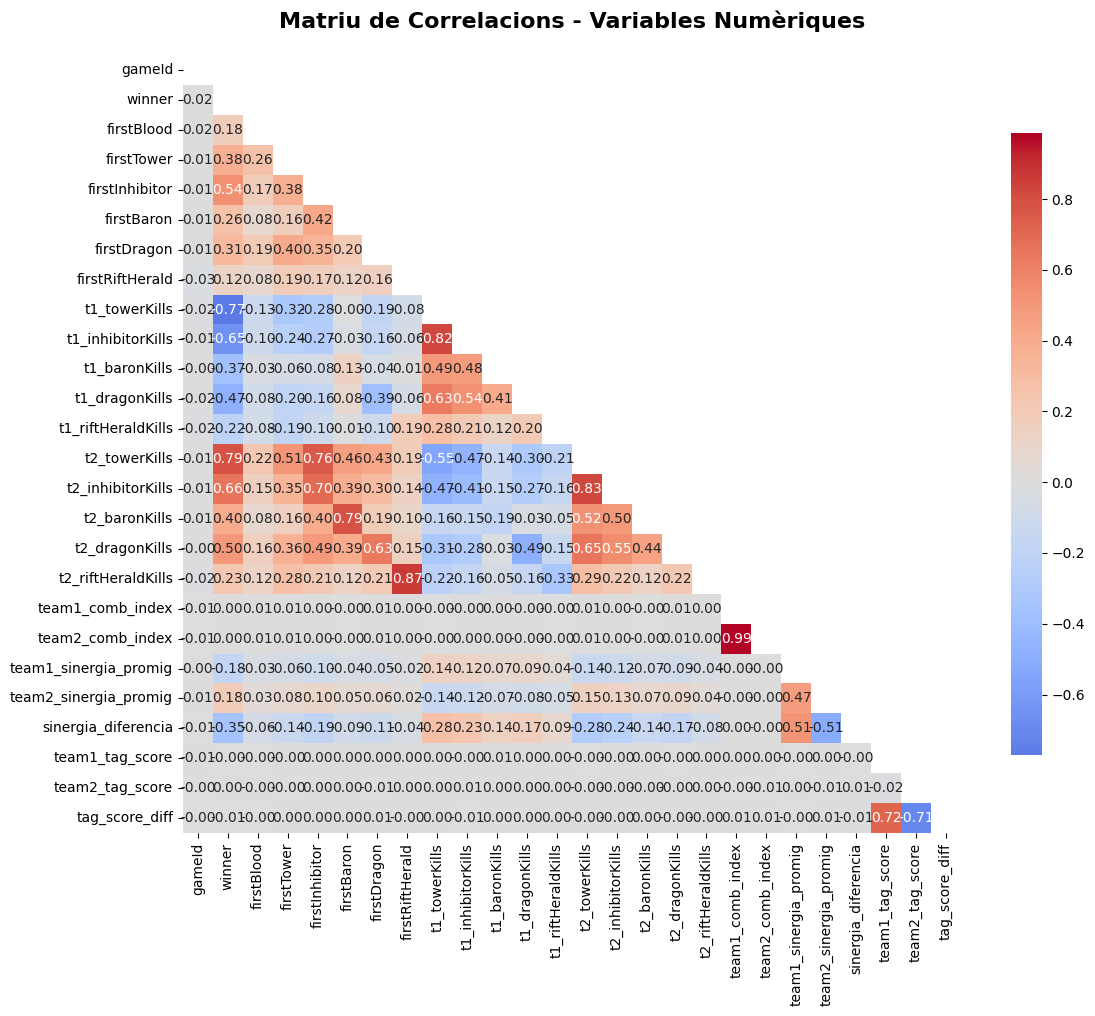


CORRELACIONS AMB EL TARGET: winner
             Variable  Correlació
        t2_towerKills    0.785722
    t2_inhibitorKills    0.660696
       firstInhibitor    0.536404
       t2_dragonKills    0.497055
        t2_baronKills    0.398692
           firstTower    0.376347
          firstDragon    0.310220
           firstBaron    0.261336
   t2_riftHeraldKills    0.226131
team2_sinergia_promig    0.183687
           firstBlood    0.175564
      firstRiftHerald    0.119891
               gameId    0.015016
     team1_comb_index    0.003700
     team2_comb_index    0.003499
      team2_tag_score    0.003135
      team1_tag_score   -0.004837
       tag_score_diff   -0.005583
team1_sinergia_promig   -0.178811
   t1_riftHeraldKills   -0.218057
  sinergia_diferencia   -0.353139
        t1_baronKills   -0.369883
       t1_dragonKills   -0.472635
    t1_inhibitorKills   -0.649636
        t1_towerKills   -0.771571


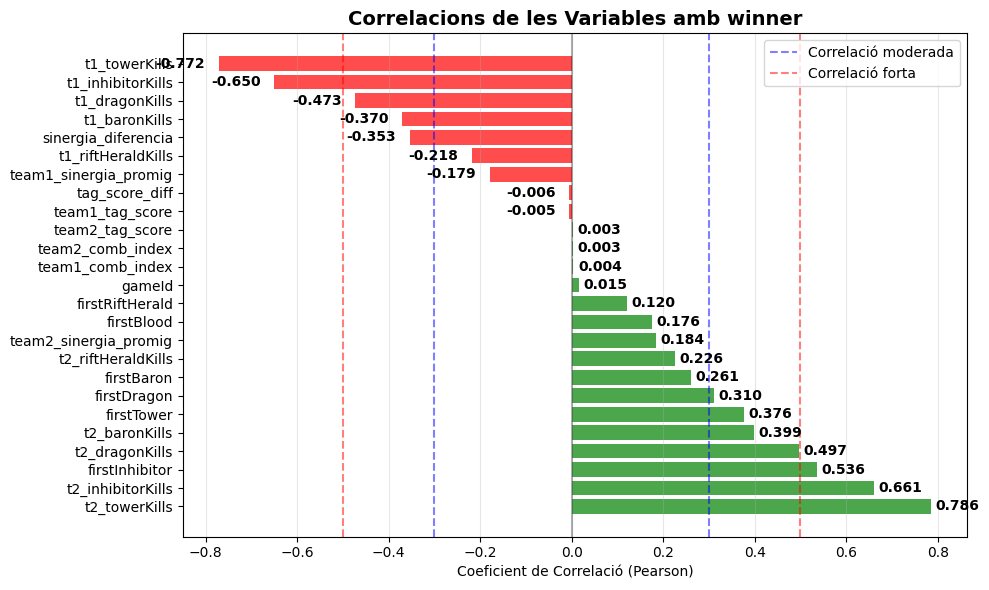


CORRELACIONS FORTES ENTRE VARIABLES (multicol·linealitat)
Correlacions fortes (> |0.5|) entre variables:
           Variable 1          Variable 2  Correlació
     team1_comb_index    team2_comb_index    0.986384
      firstRiftHerald  t2_riftHeraldKills    0.866861
        t2_towerKills   t2_inhibitorKills    0.826064
        t1_towerKills   t1_inhibitorKills    0.824581
           firstBaron       t2_baronKills    0.793116
               winner       t2_towerKills    0.785722
               winner       t1_towerKills   -0.771571
       firstInhibitor       t2_towerKills    0.755575
      team1_tag_score      tag_score_diff    0.717966
      team2_tag_score      tag_score_diff   -0.711425
       firstInhibitor   t2_inhibitorKills    0.700099
               winner   t2_inhibitorKills    0.660696
               winner   t1_inhibitorKills   -0.649636
        t2_towerKills      t2_dragonKills    0.648053
          firstDragon      t2_dragonKills    0.629829
        t1_towerKills      t1_

,gameId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,...,t2_dragonKills,t2_riftHeraldKills,team1_comb_index,team2_comb_index,team1_sinergia_promig,team2_sinergia_promig,sinergia_diferencia,team1_tag_score,team2_tag_score,tag_score_diff
gameId,1.000000,0.015016,0.017194,0.012556,0.008464,0.013243,0.005624,-0.028647,-0.021301,-0.013964,...,-0.002069,-0.017967,-0.005204,-0.005423,0.002686,0.009331,-0.006478,-0.010884,-0.004359,-0.004616
winner,0.015016,1.000000,0.175564,0.376347,0.536404,0.261336,0.310220,0.119891,-0.771571,-0.649636,...,0.497055,0.226131,0.003700,0.003499,-0.178811,0.183687,-0.353139,-0.004837,0.003135,-0.005583
firstBlood,0.017194,0.175564,1.000000,0.264325,0.170804,0.077350,0.189843,0.084182,-0.128670,-0.099121,...,0.161871,0.122499,0.005416,0.005467,-0.033372,0.032681,-0.064347,-0.004927,-0.000985,-0.002777
firstTower,0.012556,0.376347,0.264325,1.000000,0.381071,0.164939,0.404321,0.186341,-0.316782,-0.240453,...,0.364797,0.275147,0.005706,0.005519,-0.063828,0.075892,-0.136117,-0.002043,-0.004657,0.001806
firstInhibitor,0.008464,0.536404,0.170804,0.381071,1.000000,0.417355,0.352842,0.167241,-0.276164,-0.269314,...,0.487555,0.212102,0.004239,0.003851,-0.096564,0.102744,-0.194164,0.003705,0.002048,0.001178
firstBaron,0.013243,0.261336,0.077350,0.164939,0.417355,1.000000,0.201134,0.121363,-0.003266,-0.025641,...,0.393729,0.121635,-0.003152,-0.002790,-0.042483,0.048148,-0.088293,0.002743,0.001405,0.000950
firstDragon,0.005624,0.310220,0.189843,0.404321,0.352842,0.201134,1.000000,0.159920,-0.190222,-0.164389,...,0.629829,0.205668,0.008954,0.009773,-0.053975,0.063191,-0.114145,0.002261,-0.006994,0.006458
firstRiftHerald,-0.028647,0.119891,0.084182,0.186341,0.167241,0.121363,0.159920,1.000000,-0.083728,-0.059683,...,0.150474,0.866861,0.002233,0.001437,-0.017931,0.020625,-0.037562,0.001232,0.001917,-0.000469
t1_towerKills,-0.021301,-0.771571,-0.128670,-0.316782,-0.276164,-0.003266,-0.190222,-0.083728,1.000000,0.824581,...,-0.313377,-0.224786,-0.003606,-0.003385,0.138914,-0.144873,0.276461,0.001561,0.000649,0.000646
t1_inhibitorKills,-0.013964,-0.649636,-0.099121,-0.240453,-0.269314,-0.025641,-0.164389,-0.059683,0.824581,1.000000,...,-0.278992,-0.164535,-0.000044,0.000416,0.118686,-0.122001,0.234474,-0.000619,0.009628,-0.007139


In [13]:
crear_matriu_correlacio(data_set, target_attribute='winner', figsize=(12, 10))

## Model 2

In [14]:
# Eliminació columnes determinades per la primera correlació
cols_to_remove = [f't{team}_champ{i}id' for team in [1, 2] for i in range(1, 6)]
cols_to_remove += [f't{team}_champ{champ}_sum{s}' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]
cols_to_remove += [f't{team}_ban{champ}' for team in [1, 2] for champ in range(1, 6)]


# Eliminació de columnes que determinen quins herois de cada equip a acabat amb una estructura
cols_to_remove  += ['t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills',
                    't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']


# Verificar quines columnes existeixen
existing_cols = [col for col in cols_to_remove if col in data_set.columns]
data_set = data_set.drop(columns=existing_cols, errors='ignore')
print(f"Columnes restants: {data_set.shape[1]}")


Columnes restants: 16


MATRIU DE CORRELACIÓ - ANÀLISI COMPLET


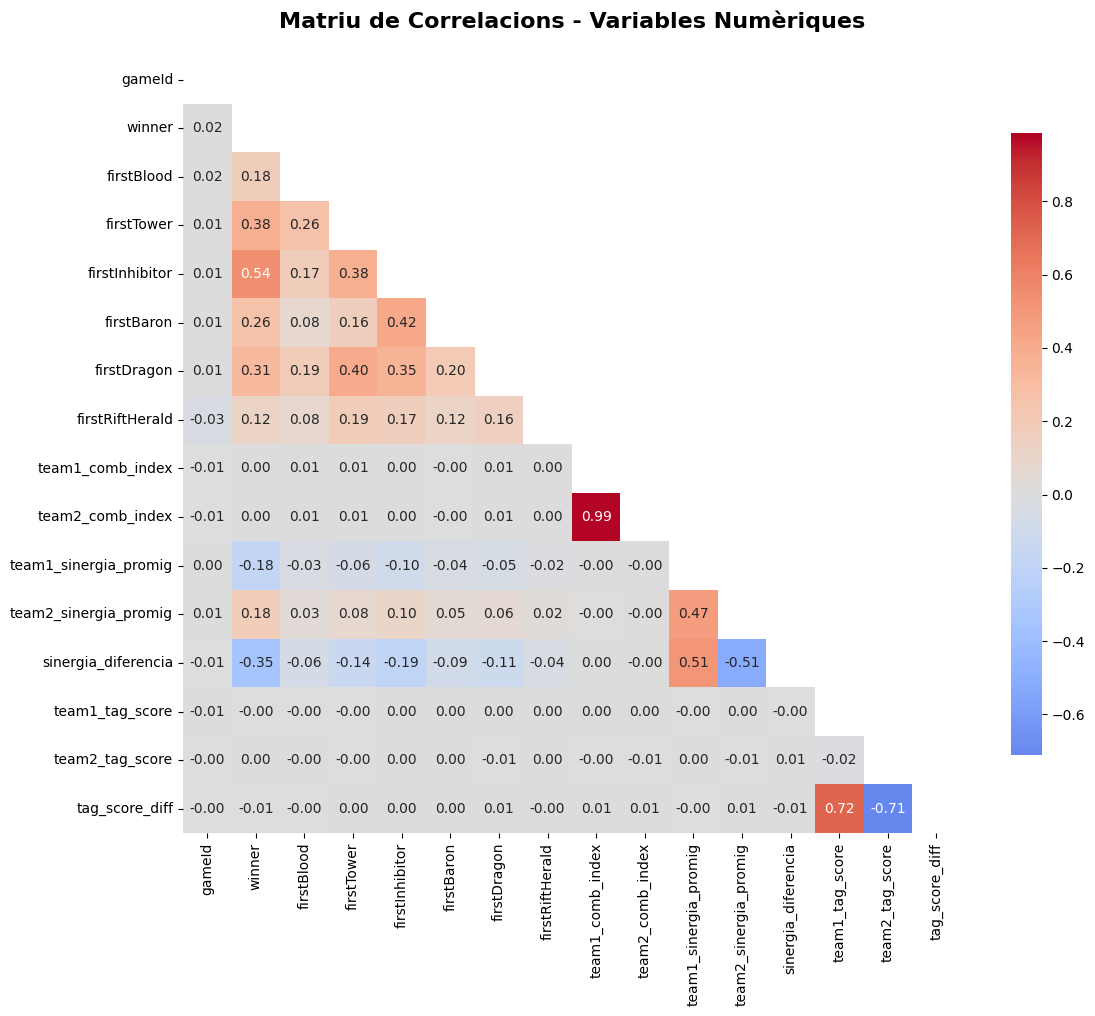


CORRELACIONS AMB EL TARGET: winner
             Variable  Correlació
       firstInhibitor    0.536404
           firstTower    0.376347
          firstDragon    0.310220
           firstBaron    0.261336
team2_sinergia_promig    0.183687
           firstBlood    0.175564
      firstRiftHerald    0.119891
               gameId    0.015016
     team1_comb_index    0.003700
     team2_comb_index    0.003499
      team2_tag_score    0.003135
      team1_tag_score   -0.004837
       tag_score_diff   -0.005583
team1_sinergia_promig   -0.178811
  sinergia_diferencia   -0.353139


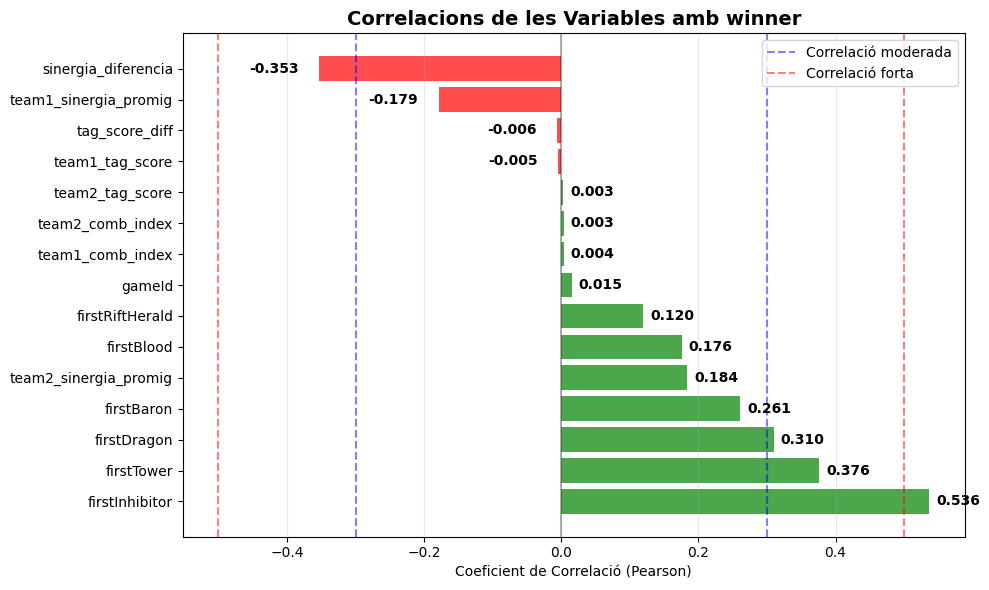


CORRELACIONS FORTES ENTRE VARIABLES (multicol·linealitat)
Correlacions fortes (> |0.5|) entre variables:
           Variable 1          Variable 2  Correlació
     team1_comb_index    team2_comb_index    0.986384
      team1_tag_score      tag_score_diff    0.717966
      team2_tag_score      tag_score_diff   -0.711425
               winner      firstInhibitor    0.536404
team2_sinergia_promig sinergia_diferencia   -0.513860
team1_sinergia_promig sinergia_diferencia    0.512646

RESUM - VARIABLES MÉS RELLEVANTS PER AL MODEL
Variables amb correlació forta/moderada amb el target (|r| > 0.05):
  - firstInhibitor: 0.536 (positiva)
  - firstTower: 0.376 (positiva)
  - firstDragon: 0.310 (positiva)
  - firstBaron: 0.261 (positiva)
  - team2_sinergia_promig: 0.184 (positiva)
  - firstBlood: 0.176 (positiva)
  - firstRiftHerald: 0.120 (positiva)
  - team1_sinergia_promig: -0.179 (negativa)
  - sinergia_diferencia: -0.353 (negativa)

Variables amb baixa correlació amb el target (|r| < 0.05):
 

,gameId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,team1_comb_index,team2_comb_index,team1_sinergia_promig,team2_sinergia_promig,sinergia_diferencia,team1_tag_score,team2_tag_score,tag_score_diff
gameId,1.000000,0.015016,0.017194,0.012556,0.008464,0.013243,0.005624,-0.028647,-0.005204,-0.005423,0.002686,0.009331,-0.006478,-0.010884,-0.004359,-0.004616
winner,0.015016,1.000000,0.175564,0.376347,0.536404,0.261336,0.310220,0.119891,0.003700,0.003499,-0.178811,0.183687,-0.353139,-0.004837,0.003135,-0.005583
firstBlood,0.017194,0.175564,1.000000,0.264325,0.170804,0.077350,0.189843,0.084182,0.005416,0.005467,-0.033372,0.032681,-0.064347,-0.004927,-0.000985,-0.002777
firstTower,0.012556,0.376347,0.264325,1.000000,0.381071,0.164939,0.404321,0.186341,0.005706,0.005519,-0.063828,0.075892,-0.136117,-0.002043,-0.004657,0.001806
firstInhibitor,0.008464,0.536404,0.170804,0.381071,1.000000,0.417355,0.352842,0.167241,0.004239,0.003851,-0.096564,0.102744,-0.194164,0.003705,0.002048,0.001178
firstBaron,0.013243,0.261336,0.077350,0.164939,0.417355,1.000000,0.201134,0.121363,-0.003152,-0.002790,-0.042483,0.048148,-0.088293,0.002743,0.001405,0.000950
firstDragon,0.005624,0.310220,0.189843,0.404321,0.352842,0.201134,1.000000,0.159920,0.008954,0.009773,-0.053975,0.063191,-0.114145,0.002261,-0.006994,0.006458
firstRiftHerald,-0.028647,0.119891,0.084182,0.186341,0.167241,0.121363,0.159920,1.000000,0.002233,0.001437,-0.017931,0.020625,-0.037562,0.001232,0.001917,-0.000469
team1_comb_index,-0.005204,0.003700,0.005416,0.005706,0.004239,-0.003152,0.008954,0.002233,1.000000,0.986384,-0.000851,-0.001979,0.000772,0.002919,-0.004239,0.005003
team2_comb_index,-0.005423,0.003499,0.005467,0.005519,0.003851,-0.002790,0.009773,0.001437,0.986384,1.000000,-0.001618,-0.000715,-0.000615,0.002287,-0.005512,0.005445


In [15]:
crear_matriu_correlacio(data_set, target_attribute='winner', figsize=(12, 10))

## Model 3

In [16]:
# Eliminació columnes determinades per la primera correlació
cols_to_remove = [f't{team}_champ{i}id' for team in [1, 2] for i in range(1, 6)]
cols_to_remove += [f't{team}_champ{champ}_sum{s}' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]
cols_to_remove += [f't{team}_ban{champ}' for team in [1, 2] for champ in range(1, 6)]


# Eliminació de columnes que determinen quins herois de cada equip a acabat amb una estructura
cols_to_remove  += ['t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills',
                    't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills',
                    'firstBlood','firstTower','firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald']


# Verificar quines columnes existeixen
existing_cols = [col for col in cols_to_remove if col in data_set.columns]
data_set = data_set.drop(columns=existing_cols, errors='ignore')
print(f"Columnes restants: {data_set.shape[1]}")


Columnes restants: 10


MATRIU DE CORRELACIÓ - ANÀLISI COMPLET


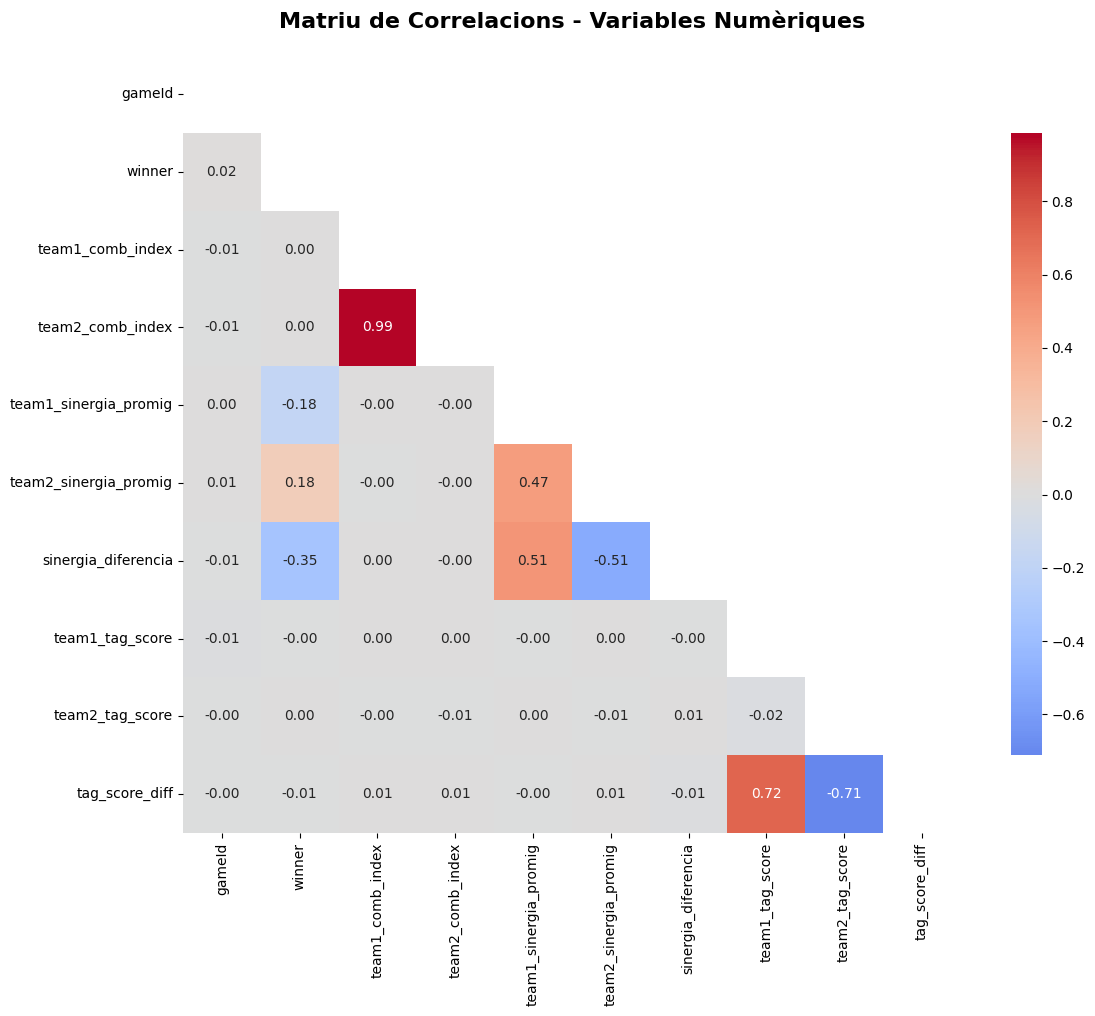


CORRELACIONS AMB EL TARGET: winner
             Variable  Correlació
team2_sinergia_promig    0.183687
               gameId    0.015016
     team1_comb_index    0.003700
     team2_comb_index    0.003499
      team2_tag_score    0.003135
      team1_tag_score   -0.004837
       tag_score_diff   -0.005583
team1_sinergia_promig   -0.178811
  sinergia_diferencia   -0.353139


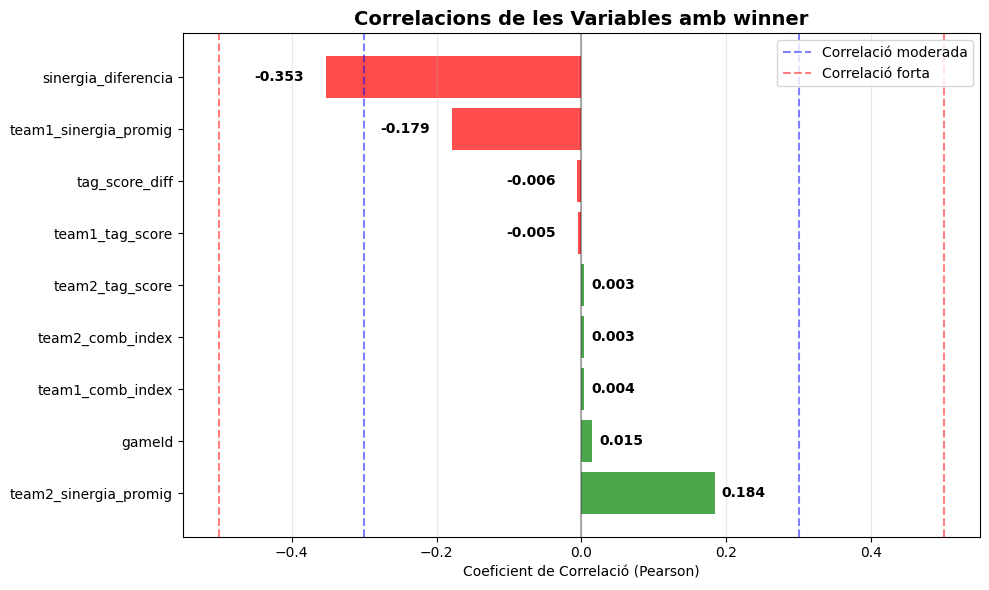


CORRELACIONS FORTES ENTRE VARIABLES (multicol·linealitat)
Correlacions fortes (> |0.5|) entre variables:
           Variable 1          Variable 2  Correlació
     team1_comb_index    team2_comb_index    0.986384
      team1_tag_score      tag_score_diff    0.717966
      team2_tag_score      tag_score_diff   -0.711425
team2_sinergia_promig sinergia_diferencia   -0.513860
team1_sinergia_promig sinergia_diferencia    0.512646

RESUM - VARIABLES MÉS RELLEVANTS PER AL MODEL
Variables amb correlació forta/moderada amb el target (|r| > 0.05):
  - team2_sinergia_promig: 0.184 (positiva)
  - team1_sinergia_promig: -0.179 (negativa)
  - sinergia_diferencia: -0.353 (negativa)

Variables amb baixa correlació amb el target (|r| < 0.05):
  - gameId: 0.015
  - team1_comb_index: 0.004
  - team2_comb_index: 0.003
  - team2_tag_score: 0.003
  - team1_tag_score: -0.005
  - tag_score_diff: -0.006


,gameId,winner,team1_comb_index,team2_comb_index,team1_sinergia_promig,team2_sinergia_promig,sinergia_diferencia,team1_tag_score,team2_tag_score,tag_score_diff
gameId,1.000000,0.015016,-0.005204,-0.005423,0.002686,0.009331,-0.006478,-0.010884,-0.004359,-0.004616
winner,0.015016,1.000000,0.003700,0.003499,-0.178811,0.183687,-0.353139,-0.004837,0.003135,-0.005583
team1_comb_index,-0.005204,0.003700,1.000000,0.986384,-0.000851,-0.001979,0.000772,0.002919,-0.004239,0.005003
team2_comb_index,-0.005423,0.003499,0.986384,1.000000,-0.001618,-0.000715,-0.000615,0.002287,-0.005512,0.005445
team1_sinergia_promig,0.002686,-0.178811,-0.000851,-0.001618,1.000000,0.473142,0.512646,-0.004043,0.002323,-0.004459
team2_sinergia_promig,0.009331,0.183687,-0.001979,-0.000715,0.473142,1.000000,-0.513860,0.000735,-0.007484,0.005727
sinergia_diferencia,-0.006478,-0.353139,0.000772,-0.000615,0.512646,-0.513860,1.000000,-0.004653,0.009556,-0.009924
team1_tag_score,-0.010884,-0.004837,0.002919,0.002287,-0.004043,0.000735,-0.004653,1.000000,-0.021602,0.717966
team2_tag_score,-0.004359,0.003135,-0.004239,-0.005512,0.002323,-0.007484,0.009556,-0.021602,1.000000,-0.711425
tag_score_diff,-0.004616,-0.005583,0.005003,0.005445,-0.004459,0.005727,-0.009924,0.717966,-0.711425,1.000000


In [17]:
crear_matriu_correlacio(data_set, target_attribute='winner', figsize=(12, 10))